In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.utils import ephemerides
from survey_ops.coreRL.data_loading import load_raw_data_to_dataframe

In [31]:
# d = fitsio.read('../data/fits/magic-spring_pointings_v0.fits')

In [34]:
# column_names = d.dtype.names
# df = pd.DataFrame(d, columns=column_names)

In [36]:
# df.to_json('../data/fits/magic-spring_pointings_v0.json')

In [8]:
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [9]:
from survey_ops.coreRL.survey_logic import relabel_mislabelled_objects, remove_specific_objects

In [13]:
a = np.array([1,23,2,2,])

In [14]:
a.count(23)

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [10]:
def save_bin_and_field_mappings(
    nside,
    objects_to_remove=None,
    specific_years=None, 
    specific_months=None, 
    specific_days=None, 
    specific_filters=None,
    data_json_fn=None,
    data_fits_fn=None,
    outdir='../data/lookups/',
    bin2radec_fn = 'bin2radec.json',
    bin2azel_fn = 'bin2azel.json',
    field2radec_fn = 'field2radec.json',
    bin2fields_in_bin_fn = 'bin2fields_in_bin.json',
    field2name_fn = 'field2name.json',
    field2nvisits_fn = 'field2nvisits.json',
):
    if data_json_fn is None:
        data_json_fn = '../data/fits/decam-exposures-20251211.json'
    if data_fits_fn is None:
        data_fits_fn = '../data/fits/decam-exposures-20251211.fits'
    
    try:
        # --- Load json df ---- #
        df = pd.read_json(data_json_fn)
        print('Loaded data from json')
    except:
        # --- Load fits ---- #
        print(data_json_fn, 'DNE. Loading and processing data from fits.')
        d = fitsio.read(data_fits_fn)
        sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
        selected_d = d[sel]
        column_names = selected_d.dtype.names
        df = pd.DataFrame(selected_d, columns=column_names)
        
        # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
        # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
        
        df.to_json(data_json_fn, indent=2)
        df = pd.read_json(data_json_fn)

    df['night'] = (df['datetime'] - pd.Timedelta(hours=12)).dt.normalize()

    # Get observations for specific years, days, filters, etc.
    if specific_years is not None:
        df = df[df['night'].dt.year.isin(specific_years)]
    if specific_months is not None:
        df = df[df['night'].dt.month.isin(specific_months)]
    if specific_days is not None:
        df = df[df['night'].dt.day.isin(specific_days)]
    if specific_filters is not None:
        df = df[df['filter'].isin(specific_filters)]
        
    df = df[df['night'].dt.year != 1970]
    assert len(df) > 0, "No observations found for the specified year/month/day/filter selections."

    df = remove_specific_nights(objects_to_remove=objects_to_remove, df=df)
    df = relabel_mislabelled_objects(df)

    # Add timestamp col
    utc = pd.to_datetime(df['datetime'], utc=True)
    timestamps = (utc.astype('int64') // 10**9).values
    df['timestamp'] = timestamps
    
    # Sort df by timestamp
    df = df.sort_values(by='timestamp')

    # convert degrees to radians
    df['el'] = np.pi/2 - df['zd'].values
    df.loc[:, ['ra', 'dec', 'az', 'el', 'zd']] *= units.deg

    hpGrid = ephemerides.HealpixGrid(nside=nside, is_azel=False)
    hpGrid_azel = ephemerides.HealpixGrid(nside=nside, is_azel=True)

    # Add bin column to dataframe
    
    if hpGrid.is_azel:
        lon = df['az']
        lat = df['el']
        # time x ra, dec --> bin: (az, el)
        # self.bin2fields = lambda time: ephemerides.equatorial_to_topographic(ra=df['az'], dec=df['el'], time=time)
        # raise NotImplementedError
    else:
        lon = df['ra']
        lat = df['dec']
        df['bin'] = hpGrid.ang2idx(lon=lon, lat=lat)

    df['field_id'] = pd.factorize(df['object'])[0]

    # bin2azel = {int(i): (lon, lat) for i, (lon, lat) in zip(hpGrid_azel.heal_idx, zip(df['az']/units.deg, df['el']/units.deg))}

    bin2radec = {int(i): (lon, lat) for i, (lon, lat) in zip(hpGrid.heal_idx, zip(hpGrid.lon, hpGrid.lat))}
    bin2azel = {int(i): (lon, lat) for i, (lon, lat) in zip(hpGrid_azel.heal_idx, zip(hpGrid_azel.lon, hpGrid_azel.lat))}
    field2radec = {int(field_id): (g.loc[:, ['ra', 'dec']]).mean(axis=0).values.tolist() for field_id, g in df.groupby('field_id')}
    bin2fields_in_bin = {int(bin_id): g['field_id'].values.tolist() for bin_id, g in df.groupby('bin')}
    field2name = {field_id: g.loc[:, ['object']].values.tolist()[0][0] for field_id, g in df.groupby('field_id')}
    field_ids, counts = np.unique(df['field_id'], return_counts=True)
    field2nvisits = {int(fid): int(count) for fid, count in zip(field_ids, counts)}
    # return field2nvisits
    # field2radec = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in field2radec.items()}
    # bin2fields_in_bin = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in bin2fields_in_bin.items()}
    
    with open(outdir + f'nside{nside}_' + bin2radec_fn, "w") as f:
        json.dump(bin2radec, f)

    with open(outdir + f'nside{nside}_' + bin2azel_fn, "w") as f:
        json.dump(bin2azel, f)

    with open(outdir + field2radec_fn, "w") as f:
        json.dump(field2radec, f)

    with open(outdir + f'nside{nside}_' + bin2fields_in_bin_fn, "w") as f:
        json.dump(bin2fields_in_bin, f)
        
    with open(outdir + field2name_fn, "w") as f:
        json.dump(field2name, f)

    with open(outdir + field2nvisits_fn, "w") as f:
        json.dump(field2nvisits, f)
    return df
    

In [19]:
nside=16
# specific_years=[2014]
# specific_months=[12]
# specific_days=[15, 16, 17, 18, 19]
specific_years=None
specific_months = None
specific_days=None

In [20]:
df = save_bin_and_field_mappings(
    nside=nside, 
    specific_years=specific_years, 
    specific_months=specific_months, 
    specific_days=specific_days
)

Loaded data from json


In [13]:
with open('../data/field2radec.json', 'r') as f:
    field2radec = json.load(f)

with open(f'../data/nside{nside}_bin2radec.json', 'r') as f:
    bin2radec = json.load(f)

with open(f'../data/nside{nside}_bin2azel.json', 'r') as f:
    bin2azel = json.load(f)

with open(f'../data/nside{nside}_bin2fields_in_bin.json', 'r') as f:
    bin2fields_in_bin = json.load(f)

In [14]:
int(list(bin2fields_in_bin.keys()))

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

Text(0, 0.5, 'dec')

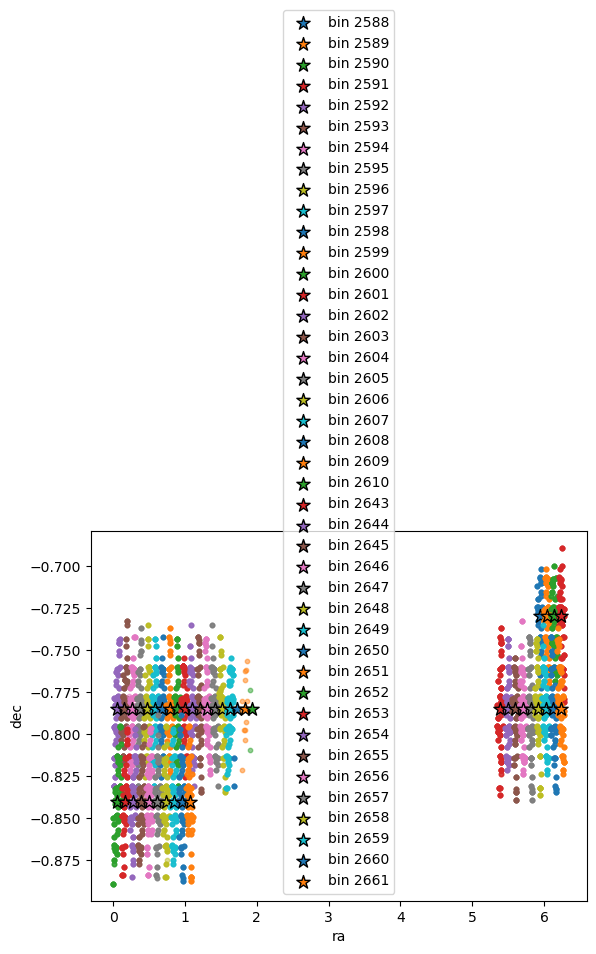

In [19]:
for i, (bin_num, fields) in enumerate(bin2fields_in_bin.items()):
    if i < 300:
        continue
    field_radecs = np.array([field2radec[str(field)] for field in fields])
    bin_radec = np.array([bin2radec[bin_num][0], bin2radec[bin_num][1]])
    plt.scatter(field_radecs[:, 0], field_radecs[:, 1], color=f'C{i}', s=10, alpha=.5)
    plt.scatter(bin_radec[0], bin_radec[1], edgecolor='black', marker='*', s=100, color=f'C{i}', label='bin ' + bin_num)
    if i > 340:
        break
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')

In [49]:
radec_1183 = np.array([field2radec[str(field)] for field in bin2fields_in_bin['1183']])

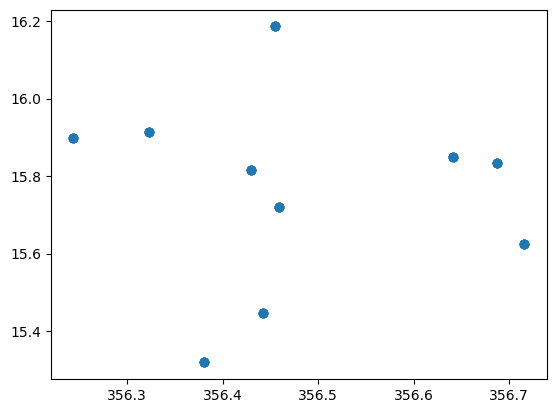

In [51]:
plt.scatter(radec_1183[:, 0], radec_1183[:, 1])

## 

In [31]:
data

{'0': [301.1989442, -50.938204],
 '1': [300.85133179999997, -52.9670374],
 '2': [300.4599266, -54.996320600000004],
 '3': [300.016665, -57.0251038],
 '4': [302.7222174, -58.03979819999999],
 '5': [305.57842416666665, -59.05444266666668],
 '6': [303.042623, -56.010558333333336],
 '7': [305.7586, -57.02529933333333],
 '8': [305.9173625, -54.996090833333334],
 '9': [303.3248568333333, -53.98160950000001],
 '10': [306.0562316, -52.9669206],
 '11': [303.5756826, -51.9526652],
 '12': [306.17989475, -50.938303749999996],
 '13': [311.1610528333333, -50.937873499999995],
 '14': [311.26104075, -52.967151],
 '15': [308.6520242, -53.981576],
 '16': [308.6378076666666, -56.010655833333324],
 '17': [308.62063059999997, -58.039414799999996],
 '18': [311.6451048, -59.0541372],
 '19': [311.5005958, -57.0252984],
 '20': [311.3733982, -54.99583700000001],
 '21': [308.664707, -51.952464000000006],
 '22': [313.75440425, -51.95251225],
 '23': [306.6295306, -40.793193200000005],
 '24': [316.14224320000005, -